In [5]:
import matlab.engine
import numpy as np
import scipy.optimize

# Trial and pd parameters

In [6]:
# trial and adherence information
drug = "ATV"

days = np.double(40) #days to run trial for
increment = 0.01 # days between each timepoint returned
prob_adh = 0.5 if drug != 'TEST' else 0. # probability of taking each pill (independent)
adh_pat = 0 # 0 = random prob for each dose, 1 = random prob each day after missed dose
adh_shuff = np.double(0.) # standard deviation in the time of taking a pill vs scheduled (days)
trial_type = 1 # 1 = suppression trial, 0=maintenance trial
burnin = 7*5 # days before interval sampling begins in maintenance trials
sampling_int = 28 # days between each sampling time in maintenance trials
threshold = 200 # threshold viral load above which failure is declared
mut_frac = 0.2 # threshold fraction of population of mutant above which declared failure via resistance

## Use existing matlab scripts to calculate concentration(t)

In [7]:
eng = matlab.engine.start_matlab()
eng.cd(r'~/develop/withinhostHIV/MatlabCode/', nargout=0)
eng.eval("addpath('Parameters','Utilities')", nargout=0)

In [8]:
eng.workspace["drug"] = drug
trial, pd = eng.trial_setup(eng.eval("drug"), days, increment, prob_adh, adh_pat, adh_shuff, trial_type, burnin, sampling_int, threshold, mut_frac, nargout=2)
eng.workspace["trial"] = trial
eng.workspace["pd"] = pd

In [9]:
dose_t, _ = eng.adh_trajectory(eng.eval("pd.num_doses"), trial, nargout=2)

In [10]:
c_vec,inhib_vec = eng.drug_trajectory(pd, trial, dose_t, nargout=2)

## Use existing matlab scripts to calculate mutation matrix Q

In [11]:
smin=0.05 #highest mutant fitness
smax=0.9 #lowest mutant fitness
smiss=0.05 #fitness of strains with missing cost
rfmiss=1 #fold change in resistance for strains with it missing
mfmiss=0 #fractional change in slope for strains with it missing
back_mutation_on = drug != 'TEST' #include(1) or exclude(0) back mutation
direct_multi_hit = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from WT
direct_multi_multi = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from one res strain to another

In [12]:
mparams,Q = eng.getMutInfo(drug,smin,smax,smiss,rfmiss,mfmiss,back_mutation_on,direct_multi_hit,direct_multi_multi,nargout=2);
eng.workspace["Q"] = Q
Q = eng.eval("Q{:,:};") # get a matrix instead of a matlab table

## Viral dynamics parameters

In [13]:
R00 = 10.0 # average number of new virions produced by infection with a single virion === average number of new infected cells produced by 1 infected cell
fbp = 0.55 # fraction of blood that is plasma
Vpl = 3*10e3 # volume of plasma in mL
ftcell_pl = 0.02 # fraction of T cells that are circulating in blood (vs in lymph system)
hl_lr = 44*30.5 # half life of decay of latent reservoir, days
A = 100 # total reactivation of latent cells per day
flr = 1e-6# fraction of CD4 T cells that are latently infected at equilibrium

scale_cd4_body = (Vpl*10**3)/(fbp*ftcell_pl) # factor to go from T cell per ul blood to whole body

fa = 0.01 # fraction of infected CD4 cells that support productive vs abortive infection
dx = 0.05 # death rate of uninfected cells (per day) and by assumption dx == d, rate of death without viral cytolytic effects
L = scale_cd4_body*1000*dx # uninfected cells produced per day (/ul)
a = A/(flr*L/dx) # rate of exit of latent cells (per day)
dz = np.log(2)/(hl_lr)-a # death rate of latently infected cells (per day)

dy = 1 # TOTAL death rate of infected cells (per day) (=death due to burst (k) + death without viral cytolytic effects)
k = dy-dx # rate of death+emission of a burst of virions (per day)
p_est = 4.2e-4
N = scipy.optimize.least_squares(lambda N: R00*(1-(1-p_est)**N) - N*p_est, 100000, bounds=(10.0, np.inf))
assert(N.success)
N = round(N.x[0])
assert(N > R00)

c = 23.04 # clearance of virions (per day) Ramratnam et al. Lancet 1999 [calculated as average over the 4 patients]
dv = c # APPROXIMATION
beta = R00 * dx * dy * dv / (L * (fa) * k * N)

g = flr*dy/dx*(a+dz)/(fa*(1-1/R00)) # fraction of new infections that become latent

m = 1.0 # combined rate of maturation + death of eclipsed cells [right now not drawn from any source]

In [14]:
# Access matlab parameters
eng.workspace["mparams"] = mparams
IC50 = eng.eval('pd.IC50')
m = eng.eval('pd.m')
cost = eng.eval('mparams.cost')
rf = eng.eval('mparams.rf')
mf = eng.eval('mparams.mf')
msb = np.asarray(eng.eval("mparams.msb"))
t_vec = eng.eval('(0:trial.increment:trial.days);')


## Check beta(t) (from matlab) against beta(t) (from python)

In [15]:
_beta_t, _beta_u_t = eng.calculate_beta_of_t(t_vec, beta, c_vec, IC50, m, cost, rf, mf, eng.eval('height(mparams)'), nargout=2)

In [16]:
from numba import jit

@jit(nopython=True)
def calculate_beta_t(beta_0, concentration, IC50, m, cost, rf, mf):
    # B/[cost * (1 + concentration)/(IC50*rf)^(m*(1+mf))]
    B = beta_0
    denominator = cost * (1 + (concentration/(IC50*rf))**(m*(1+mf)))
    return B/denominator


# make sure we didn't mess up our function definition
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T), np.asarray(_beta_u_t)))
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1), np.asarray(_beta_t)))

beta_u_t = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T)
beta_t   = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1)

beta_t = np.concatenate([beta_t, beta_u_t], axis=1)
t_vec = np.asarray(t_vec).squeeze()
dose_t = np.asarray(dose_t).T.squeeze()

In [17]:
sampled_concentration = np.asarray(c_vec)

increment = eng.eval('trial.increment')

# closed around parameters
# pulls the nearest beta pre-calculated to the left of the current time
@jit(nopython=True)
def discrete_beta_of_t(t):
    # last time where beta was precalculated *before* t
    # specifically want *before* t so that we don't look ahead while integrating past a discontinuity
    t_discrete = int(np.floor(t/increment))
    return beta_t[t_discrete]

Q = np.asarray(Q)
@jit(nopython=True)
def force_of_infection(t):
    beta = discrete_beta_of_t(t)
    # calculate force of infection and flatten in row major order, which will make the matrix
    # read correctly in our 1-dimensional vector of rates

    # **NOTE* we moved FA to the stoichiometry matrix, otherwise it would be a factor below!
    return (np.expand_dims(beta,1) * Q).flatten()

@jit(nopython=True)
def combined_productive_unproductive_force_of_infection(t):
    beta = discrete_beta_of_t(t)
    beta_productive = beta * fa
    beta_unproductive = beta * (1 - fa)

    # calculate force of infection including mutation and flatten in row major order,
    # which will make the matrix read correctly in our 1-dimensional vector of rates
    productive_ks = (np.expand_dims(beta_productive,1) * Q).flatten()
    # if we weren't in jit we would want:
    # np.concatenate([productive_ks, unproductive_ks])
    foi = np.zeros(len(productive_ks)+len(beta_unproductive))
    foi[:len(productive_ks)] = productive_ks
    # since unproductive infections don't produce new strains, we can ignore mutation
    foi[len(productive_ks):] = beta_unproductive
    
    return foi

TODO: triple check to make sure this is the right orientation of beta_i relative to Q

# Define model

In [18]:
import reactionmodel.model as reactionmodel
num_strains = beta_t.shape[1]
num_strains

4

In [19]:
beta

3.7351443123938885e-13

In [20]:
ys = [reactionmodel.Species(f'Y{i}', f'infected cells strain {i}') for i in range(num_strains)]
zs = [reactionmodel.Species(f'Z{i}', f'latent cells strain {i}', ) for i in range(num_strains)]
ws = [reactionmodel.Species(f'W{i}', f'eclipsed cells strain {i}') for i in range(num_strains)]
vs = [reactionmodel.Species(f'V{i}', f'virus particle strain {i}') for i in range(num_strains)]

x = reactionmodel.Species("X", "target cells")
all_species = [x] + ys + ws + zs + vs

In [21]:
target_cell_birth = reactionmodel.Reaction([], [x], description="target cell birth", k=L)
target_cell_death = reactionmodel.Reaction([x], [], description="target cell death", k=dx)

infected_death = [reactionmodel.Reaction([ys[i]], [], description=f"death of infected cell strain (without burst) {i}", k=(dy-k)) for i in range(num_strains)]
infected_cell_burst = [reactionmodel.Reaction([ys[i]], [(vs[i], N)], description=f"burst of infected cell strain {i}", k=k) for i in range(num_strains)]

into_latency = [reactionmodel.Reaction([ys[i]], [zs[i]], description=f"strain {i} --> latency", k=g) for i in range(num_strains)]
out_of_latency = [reactionmodel.Reaction([zs[i]], [ys[i]], description=f"latent --> strain {i}", k=a) for i in range(num_strains)]
death_of_latent = [reactionmodel.Reaction([zs[i]], [], description=f"latent {i} death", k=dz) for i in range(num_strains)]

maturation_of_eclipse = [reactionmodel.Reaction([ws[i]], [ys[i]], description=f"productive maturation of strain {i} eclipsed", k=m) for i in range(num_strains)]
# only model productively infected eclipsed cells
# eclipse_death = [reactionmodel.Reaction([ws[i]], [], description=f"death of strain {i} eclipsed", k=m*(1-fa)) for i in range(num_strains)]

viral_clearance = [reactionmodel.Reaction([vs[i]], [], description=f"clearance of strain {i} virion", k=c) for i in range(num_strains)]

#infections = []
#for i in range(num_strains):
#    for j in range(num_strains):
#        infections.append(reactionmodel.Reaction([x, vs[i]], [ws[j]], description=f"infection of x by v{i}->w{j}"))
#infection_family = reactionmodel.ReactionRateFamily(infections, k=force_of_infection)

In [22]:
productive_infections = []
unproductive_infections = []
for i in range(num_strains):
    unproductive_infections.append(reactionmodel.Reaction([x, vs[i]], [], description=f"unproductive infection of x by {i}->empty set"))
    for j in range(num_strains):
        productive_infections.append(reactionmodel.Reaction([x, vs[i]], [ws[j]], description=f"productive infection of x by {i}->{j}"))

infection_family = reactionmodel.ReactionRateFamily(productive_infections + unproductive_infections, k=combined_productive_unproductive_force_of_infection)

In [23]:
all_reactions = [target_cell_birth, target_cell_death] + infected_death + infected_cell_burst + into_latency + out_of_latency + death_of_latent + maturation_of_eclipse + viral_clearance + [infection_family]

In [24]:
model = reactionmodel.Model(all_species, all_reactions)

In [25]:
poisson_products_mask = np.array(['burst of infected cell' in r.description for r in model.all_reactions])

# Run forward simulation

## Initial condition

In [27]:
extra_discontinuities = list(np.linspace(0.0,40.0,400))
extra_discontinuities = []

y0 = np.zeros(len(all_species))
y0[model.species_index[x]] = L/dx/R00

expanded_msb = np.squeeze(np.vstack([np.array([1]), msb]))
y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] = fa*(1-1/R00)*L/dy * expanded_msb
y0[model.species_index[zs[0]] : model.species_index[zs[-1]] + 1] = y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] * g/(a+dz)
y0[model.species_index[ws[0]] : model.species_index[ws[-1]] + 1] = y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] * y0[model.species_index[x]] * fa * (k*N/c)*beta / m
y0[model.species_index[vs[0]] : model.species_index[vs[-1]] + 1] = y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] * k * N / c

In [24]:
fa*(1-1/R00)*L/dy

1227272727.2727273

## N specimen partitioning

In [39]:
from hybrid.hybrid import HybridSimulator, NThresholdPartitioner

In [40]:
model.all_reactions

[Reaction(description=target cell birth, reactants=(), products=(Species(name='X', description='target cells'),), kinetic_order=(), k=136363636363.63635),
 Reaction(description=target cell death, reactants=(Species(name='X', description='target cells'),), products=(), kinetic_order=(Species(name='X', description='target cells'),), k=0.05),
 Reaction(description=death of infected cell strain (without burst) 0, reactants=(Species(name='Y0', description='infected cells strain 0'),), products=(), kinetic_order=(Species(name='Y0', description='infected cells strain 0'),), k=0.050000000000000044),
 Reaction(description=death of infected cell strain (without burst) 1, reactants=(Species(name='Y1', description='infected cells strain 1'),), products=(), kinetic_order=(Species(name='Y1', description='infected cells strain 1'),), k=0.050000000000000044),
 Reaction(description=death of infected cell strain (without burst) 2, reactants=(Species(name='Y2', description='infected cells strain 2'),), p

In [41]:
# the adherence pattern and hence the R0s is being determined in matlab before any of this code runs,
# so don't be scared if trajectories look almost identical with different seeds in python
simulator = HybridSimulator(
    model.get_k(jit=True),
    model.stoichiometry(),
    model.kinetic_order(),
    NThresholdPartitioner(100),
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    fast_scale='langevin',
    approximate_rtot=True,
    contrived_no_reaction_rate=20.0,
    jit=True,
    species_labels=[s.name for s in model.species],
    pathway_labels=[r.description for r in model.all_reactions],
    euler_maruyama_timestep=0.001,
    poisson_products_mask=poisson_products_mask
)

In [43]:
rng = np.random.default_rng(0)
result = simulator.simulate([0, 40.0], y0, rng)

Doing surgery to avoid discontinuity: skipping from 0.9999999999999999 to 1.0000000000000002
Doing surgery to avoid discontinuity: skipping from 8.999999999999998 to 9.000000000000002
Doing surgery to avoid discontinuity: skipping from 10.999999999999998 to 11.000000000000002
Doing surgery to avoid discontinuity: skipping from 12.999999999999998 to 13.000000000000002
Doing surgery to avoid discontinuity: skipping from 14.999999999999998 to 15.000000000000002
Doing surgery to avoid discontinuity: skipping from 16.999999999999996 to 17.000000000000004
Doing surgery to avoid discontinuity: skipping from 19.999999999999996 to 20.000000000000004
Doing surgery to avoid discontinuity: skipping from 20.999999999999996 to 21.000000000000004
Doing surgery to avoid discontinuity: skipping from 22.999999999999996 to 23.000000000000004
Doing surgery to avoid discontinuity: skipping from 23.999999999999996 to 24.000000000000004
Doing surgery to avoid discontinuity: skipping from 24.999999999999996 t

In [44]:
result.pathway_counter

Counter({7.0: 9119,
         6.0: 3753,
         9.0: 3408,
         8.0: 2304,
         28.0: 868,
         -1.0: 790,
         25.0: 720,
         29.0: 713,
         45.0: 606,
         27.0: 594,
         24.0: 363,
         22.0: 344,
         23.0: 336,
         30.0: 288,
         32.0: 138,
         40.0: 129,
         31.0: 127,
         35.0: 111,
         inf: 20,
         33.0: 18,
         5.0: 15,
         4.0: 8,
         3.0: 3,
         48.0: 1,
         49.0: 1})

In [45]:
simulator.pathway_labels[32]

'productive infection of x by 0->2'

(1e-07, 1000.0)

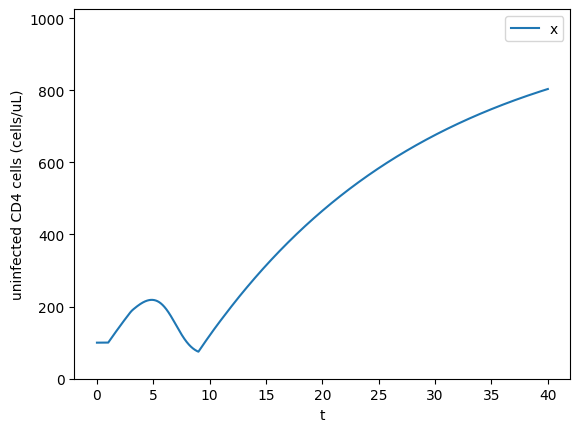

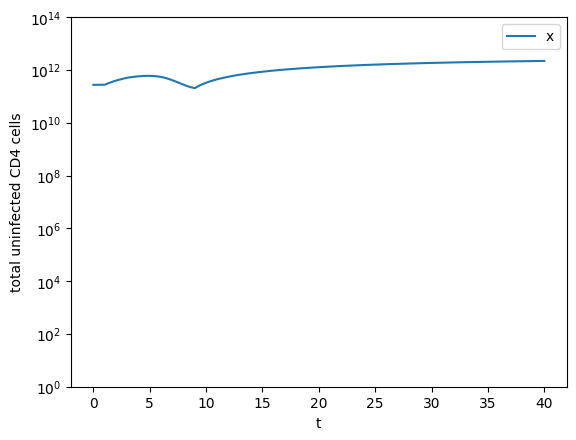

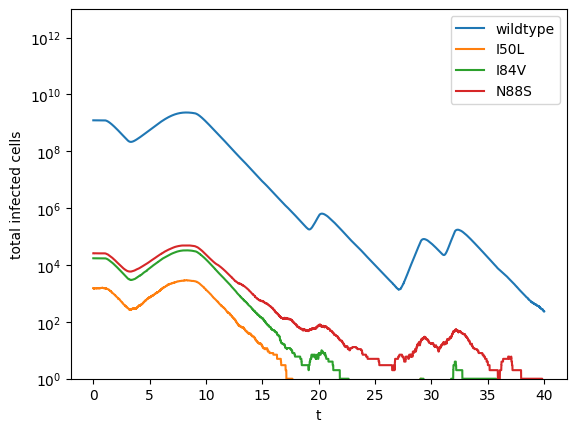

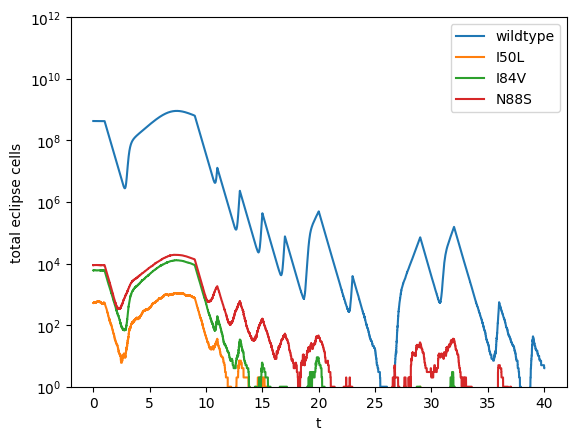

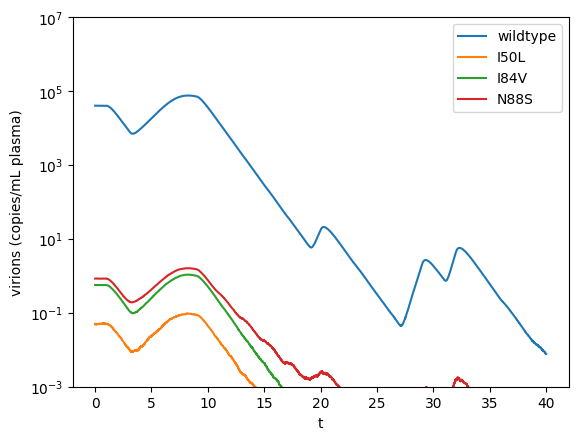

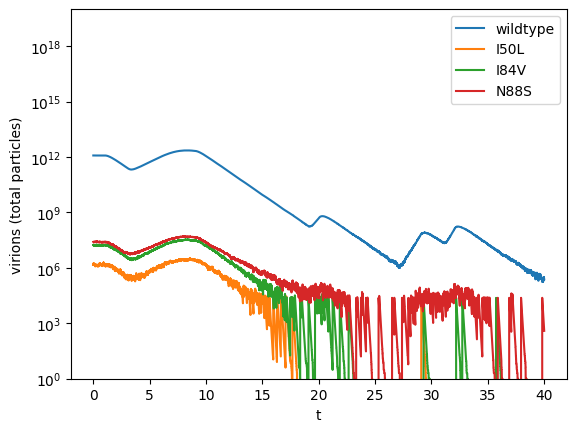

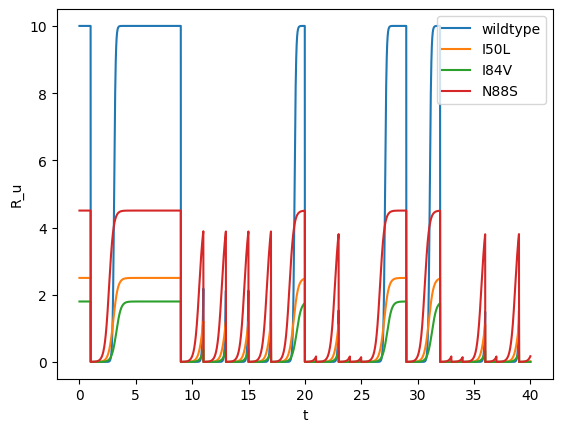

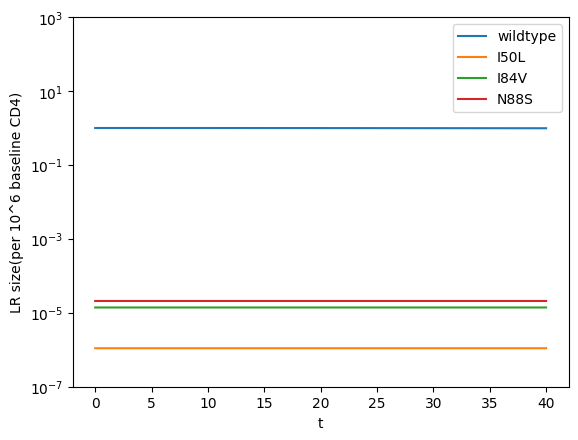

In [46]:
import matplotlib.pyplot as plt

mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[0].T, label='x')
plt.yscale('log')
plt.ylabel('total uninfected CD4 cells')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e14])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('total infected cells')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e13])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species_index[ws[0]]:model.species_index[ws[-1]]+1].T, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('total eclipse cells')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e12])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(ys[0]):model.species.index(ys[-1])+1].T*k*N/c/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species_index[vs[0]]:model.species_index[vs[-1]]+1].T, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (total particles)')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e20])


plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])

## Tau leaping

In [29]:
from hybrid.tau import TauLeapSimulator

# burst into virions
equilibrium_mask = [True if ('burst of infected cell' in r.description or 'clearance' in r.description) else False for r in model.all_reactions]
equilibrium_mask = np.array(equilibrium_mask)
#assert np.count_nonzero(equilibrium_mask) == 32

t_simulator = TauLeapSimulator(
    model.get_k(jit=True),
    model.stoichiometry(),
    model.kinetic_order(),
    discontinuities=dose_t,
    jit=True,
    species_labels=[s.name for s in model.species],
    pathway_labels=[r.description for r in model.all_reactions],
    epsilon=0.01,
    species_creation_is_critical=False,
    method='implicit',
    equilibrium_mask=equilibrium_mask,
    poisson_products_mask=poisson_products_mask
)

In [32]:
rng = np.random.default_rng(0)
result = t_simulator.simulate([0, 13.0], y0, rng)

Doing surgery to avoid discontinuity: skipping from 0.9999999999999999 to 1.0000000000000002
Doing surgery to avoid discontinuity: skipping from 8.999999999999998 to 9.000000000000002
Doing surgery to avoid discontinuity: skipping from 10.999999999999998 to 11.000000000000002


In [33]:
result.status_counter

Counter({<TauStepStatus.leap: 2>: 8656,
         <TauStepStatus.leap_critical_combined: 3>: 25,
         <TauStepStatus.t_end_for_discontinuity: 1>: 3,
         <TauStepStatus.t_end: 0>: 1})

In [34]:
%load_ext jupyterflame

In [ ]:
%%flame
rng = np.random.default_rng(0)
t_simulator.simulate([0, 40.0], y0, rng)

In [36]:
taus = [result.t_history[i+1] - result.t_history[i] for i in range(len(result.t_history)-1)]
plt.hist(taus)

NameError: name 'plt' is not defined

(1e-07, 1000.0)

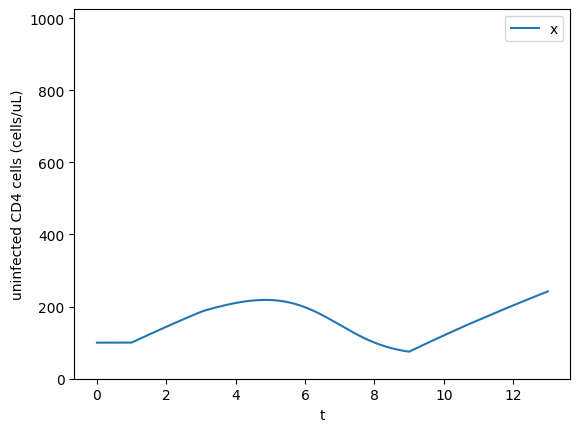

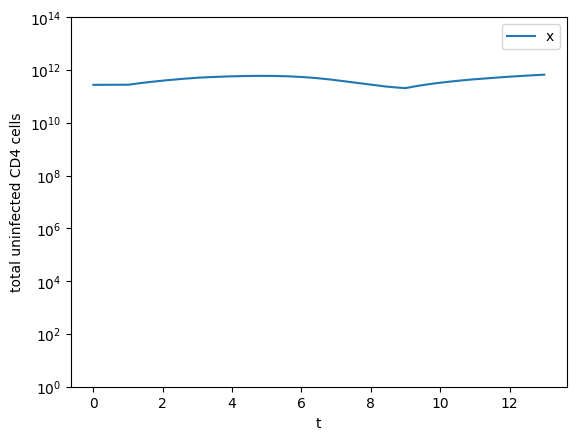

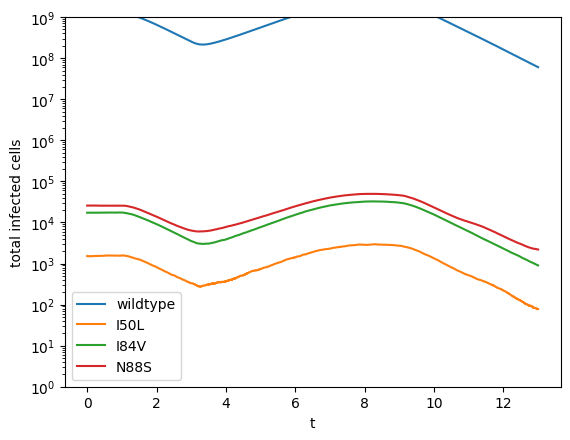

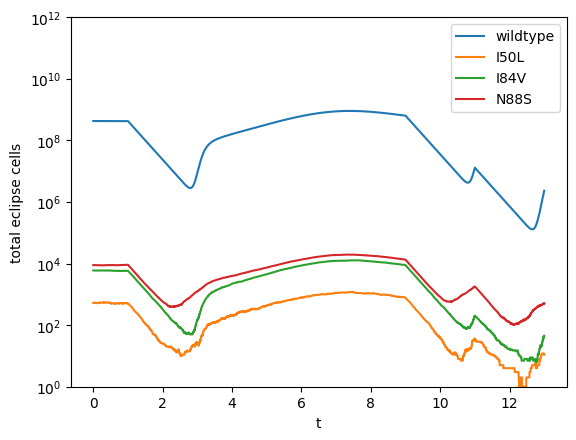

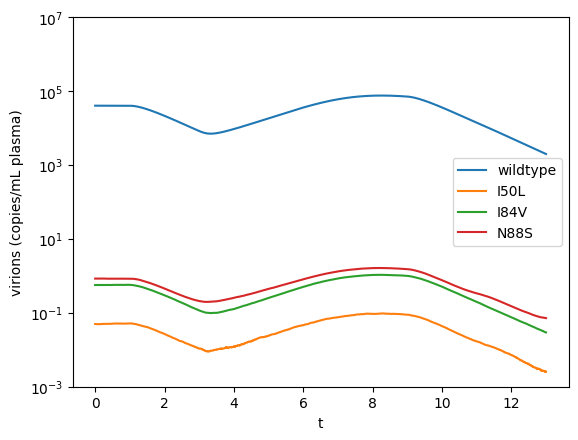

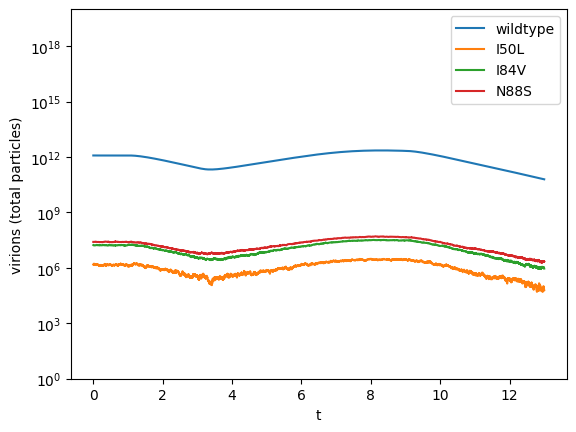

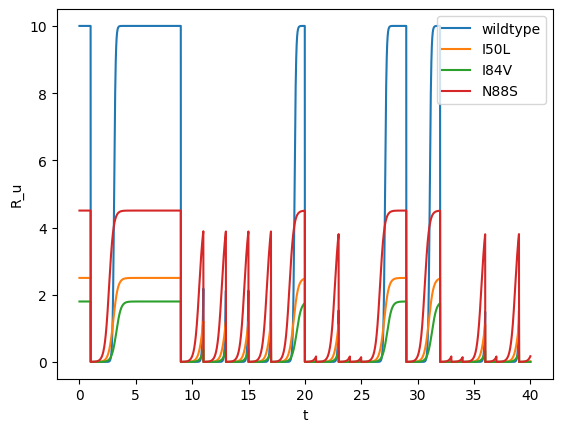

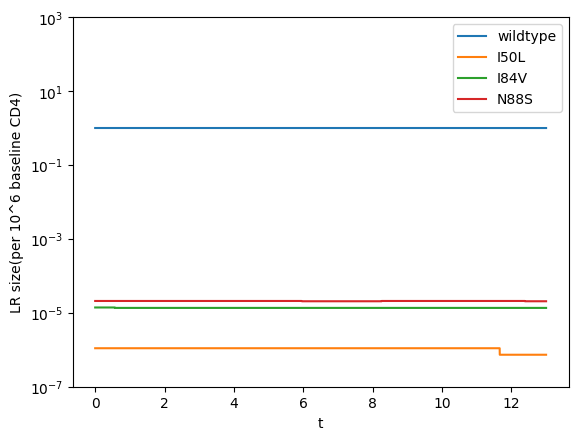

In [37]:
import matplotlib.pyplot as plt

mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[0].T, label='x')
plt.yscale('log')
plt.ylabel('total uninfected CD4 cells')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e14])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('total infected cells')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e9])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species_index[ws[0]]:model.species_index[ws[-1]]+1].T, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('total eclipse cells')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e12])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(ys[0]):model.species.index(ys[-1])+1].T*k*N/c/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species_index[vs[0]]:model.species_index[vs[-1]]+1].T, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (total particles)')
plt.xlabel('t')
plt.legend()
plt.ylim([1, 1e20])

plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])